In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U efficientnet
!pip install -U git+https://github.com/qubvel/efficientnet
!pip install -U --pre efficientnet

     |████████████████████████████████| 51kB 7.3MB/s 
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-rdd7j3d4
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-rdd7j3d4
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp37-none-any.whl size=18421 sha256=55a57045a557c00da67ff7b3e7586bf4008ff0b362171c576cb473212249f23d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ktx44tlk/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1
Requirement already up-to-date: efficientnet in /usr/local/lib/python3.7/dist-packages (1.1.1)


In [3]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=064f85e74f7c0f8dd27aed5ac834092b7d006d7ad22c751f5e9d6ece5581fe94
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [4]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b0')

In [5]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [6]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

# ... image preprocessing as in the classification example ...
print(img.shape) # torch.Size([1, 3, 224, 224])

features = model.extract_features(img)
print(features.shape) # torch.Size([1, 1280, 7, 7])

Loaded pretrained weights for efficientnet-b0


NameError: ignored

In [7]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'  # b5

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=15)

224
Loaded pretrained weights for efficientnet-b0


In [8]:
batch_size  = 128
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

## make dataset
from torchvision import transforms, datasets
data_path = './drive/MyDrive/mushroom_project/new_mush/'  # class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
mush_dataset = datasets.ImageFolder(
                                data_path,
                                transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                ]))
## data split
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, tmp_idx = train_test_split(list(range(len(mush_dataset))), test_size=0.1, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(mush_dataset, train_idx)
tmp_dataset       = Subset(mush_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=random_seed)
datasets['valid'] = Subset(tmp_dataset, val_idx)
datasets['test']  = Subset(tmp_dataset, test_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 128,  tvt : 21 / 2 / 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


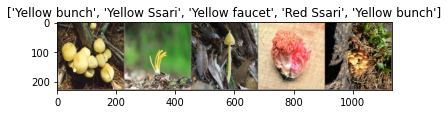

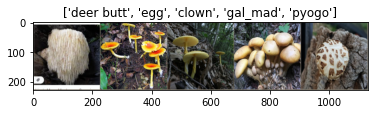

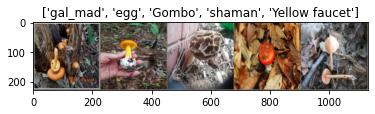

In [9]:
## 데이타 체크
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 5

class_names = {
    "0": "clown",      # "0": "개나리광대버섯"
    "1": "Gombo",   # "1": "곰보버섯"
    "2": "Yellow faucet",   # "2": "노란꼭지버섯"
    "3": "Yellow bunch",  # "3": "노란다발버섯"
    "4": "Yellow Ssari",   # "4": "노란싸리버섯"
    "5": "deer butt",   # "5": "노루궁뎅이버섯"
    "6": "egg",   # "6": "달걀버섯"
    "7": "Red Ssari",      # "7": "붉은싸리버섯"
    "8": "tree",   # "8": "뽕나무버섯"
    "9": "Ssari",   # "9": "싸리버섯"
    "10": "pyogo",  # "10": "표고버섯"
    "11": "shaman",   # "11": "혈색무당  
    "12": "gaeam", #"12": "개암버섯"
    "13": "yellow nan", #"13": "노란난버섯"
    "14": "gal_mad" #"14": "갈황색미치광이버섯"
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'mushroom_classification_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.0001,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200)

Epoch 0/199
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.92 Acc: 64.8
valid Loss: 1.97 Acc: 64.4
==> best model saved - 0 / 64.4
Epoch 1/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.92 Acc: 64.0
valid Loss: 1.97 Acc: 64.4
Epoch 2/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.92 Acc: 64.7
valid Loss: 1.96 Acc: 63.7
Epoch 3/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.91 Acc: 64.9
valid Loss: 1.96 Acc: 63.7
Epoch 4/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.91 Acc: 65.8
valid Loss: 1.95 Acc: 63.7
Epoch 5/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.90 Acc: 65.4
valid Loss: 1.95 Acc: 65.1
==> best model saved - 5 / 65.1
Epoch 6/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.90 Acc: 67.0
valid Loss: 1.95 Acc: 65.1
Epoch 7/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.89 Acc: 66.3
valid Loss: 1.94 Acc: 65.8
==> best model saved - 7 / 65.8
Epoch 8/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.89 Acc: 65.9
valid Loss: 1.94 Acc: 66.4
==> best model saved - 8 / 66.4
Epoch 9/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.89 Acc: 65.0
valid Loss: 1.94 Acc: 66.4
Epoch 10/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.89 Acc: 65.8
valid Loss: 1.93 Acc: 66.4
Epoch 11/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.88 Acc: 65.6
valid Loss: 1.93 Acc: 66.4
Epoch 12/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.88 Acc: 65.8
valid Loss: 1.92 Acc: 66.4
Epoch 13/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.87 Acc: 65.6
valid Loss: 1.92 Acc: 66.4
Epoch 14/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.87 Acc: 65.8
valid Loss: 1.92 Acc: 66.4
Epoch 15/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.87 Acc: 65.8
valid Loss: 1.91 Acc: 66.4
Epoch 16/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.86 Acc: 65.9
valid Loss: 1.91 Acc: 66.4
Epoch 17/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.86 Acc: 66.5
valid Loss: 1.91 Acc: 66.4
Epoch 18/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.85 Acc: 66.1
valid Loss: 1.90 Acc: 66.4
Epoch 19/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.86 Acc: 66.4
valid Loss: 1.90 Acc: 66.4
Epoch 20/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.84 Acc: 66.2
valid Loss: 1.90 Acc: 66.4
Epoch 21/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.84 Acc: 66.2
valid Loss: 1.89 Acc: 66.4
Epoch 22/199
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


best model : 99 - 64 / 2.0


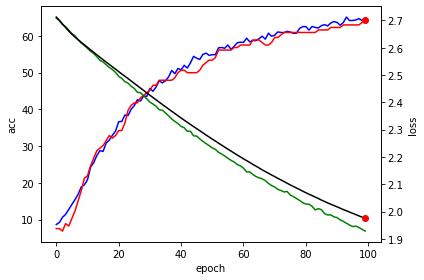

In [13]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test done : loss/acc : 1.91 / 68.5


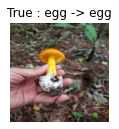

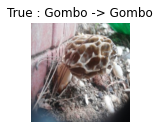

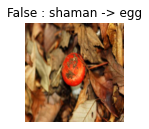

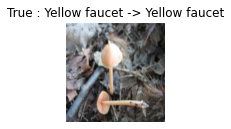

In [14]:
def test_and_visualize_model(model, phase = 'test', num_images=4):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)        

            # 예시 그림 plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                    class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                imshow(inputs.cpu().data[j])          
            if i == 0 : break


    model.train(mode=was_training);  # 다시 train모드로
    
    ## TEST!
test_and_visualize_model(model, phase = 'test')

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('모델이름.tflite', 'wb') as f:
  f.write(tflite_model)
